In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
data = load_wine()
target = load_wine().target
df = pd.DataFrame(data.data, columns=data.feature_names)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [3]:
data.data.shape

(178, 13)

In [4]:
num_epochs = 2000 # 5000
batch_size = 16
dataset = torch.tensor(df_scaled, dtype=torch.float32)

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

input_dim = df.shape[1]
encoding_dim = 2
model = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

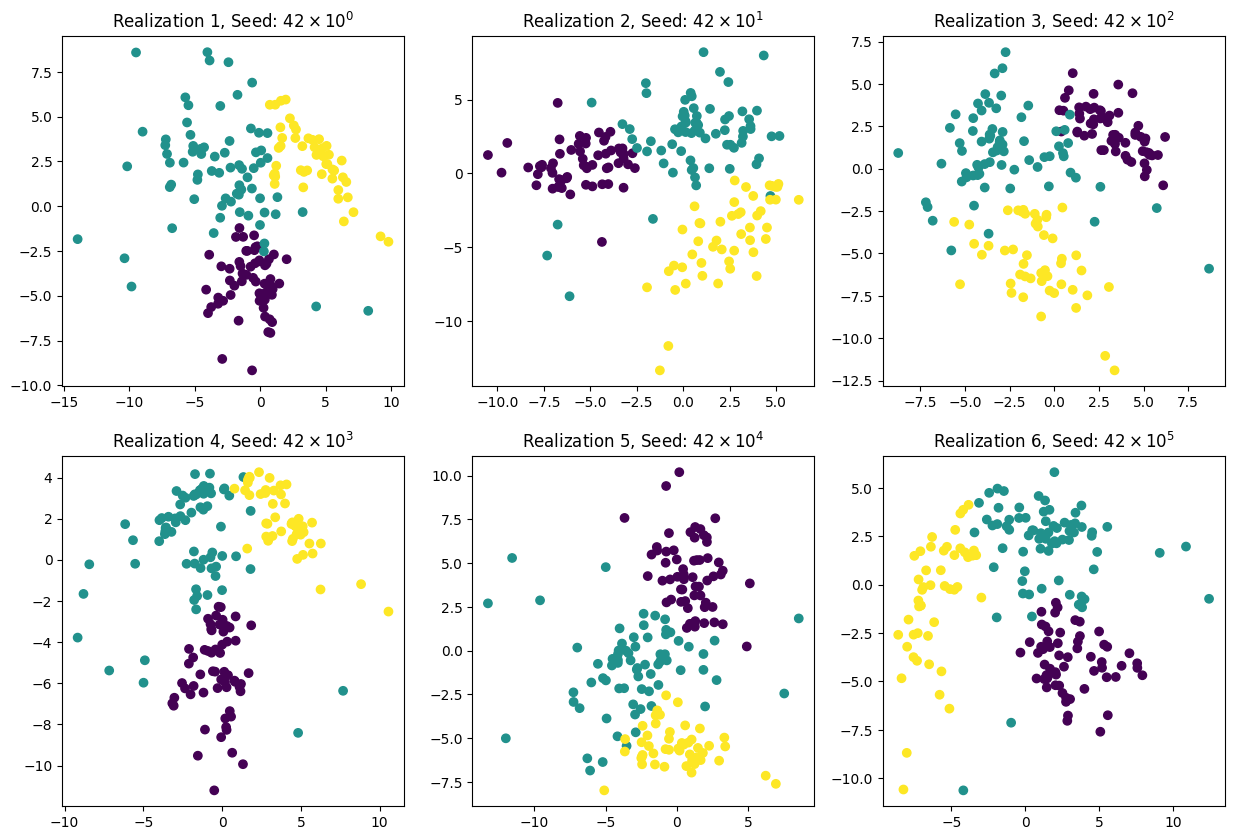

In [6]:
# Generate a sequence of seed values
initial_seed = 42
random.seed(initial_seed)
num_seeds = 6
seed_values = [initial_seed * (10 ** i) for i in range(num_seeds)]

# Prepare a 3x3 grid for latent space visualization
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

# Loop over each seed
all_losses = []  # to store losses for all runs

for idx, seed in enumerate(seed_values):
    # Set the seed for reproducibility
    torch.manual_seed(seed)
    random.seed(seed)  # For Python's random module

    # Create a generator for DataLoader and set its seed
    generator = torch.Generator().manual_seed(seed)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=generator)

    # Initialize model, optimizer, and other states
    model = Autoencoder(input_dim, encoding_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    losses = []

    # Training
    for epoch in range(num_epochs):
        epoch_loss = 0
        for data in dataloader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        avg_epoch_loss = epoch_loss / len(dataloader)
        losses.append(avg_epoch_loss)

    all_losses.append(losses)

    # Latent space visualization
    with torch.no_grad():

        encoded_data = model.encoder(dataset).numpy()
        axs[idx].scatter(encoded_data[:, 0], encoded_data[:, 1], c=target, cmap='viridis')
        title = f'Realization {idx + 1}, Seed: $42 \\times 10^{idx}$'
        axs[idx].set_title(title)


The above is the latent feature space colored by the truth labels from the response feature in the dataset used

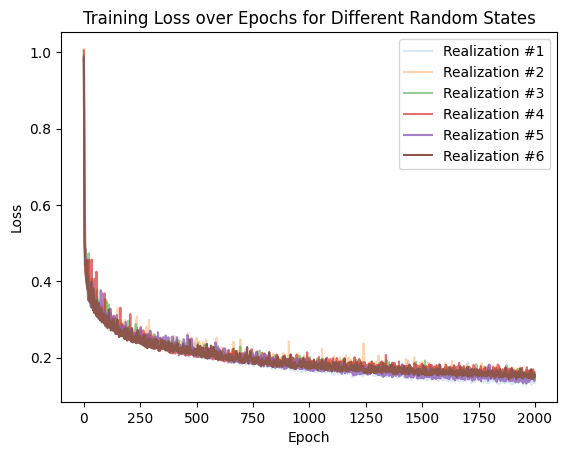

In [7]:
# Generate alpha values within the range [0, 1]
alphas = [i/num_seeds for i in range(1, num_seeds + 1)]
real_values = [1, 2, 3, 4, 5, 6]

for idx, losses in enumerate(all_losses):
    # plt.plot(losses, label=f'Seed: {seed_values[idx]}', alpha=alphas[idx])
    plt.plot(losses, label=f'Realization #{real_values[idx]}', alpha=alphas[idx])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs for Different Random States')
plt.legend()
plt.show()